# Exposures and Dark Frames

In this notebook you will:
- Learn how to manipulate samples, shutters, and measure on a simulated diffraction beamline
- Design and implement a custom scan plan to manage dark-image subtraction
- Collect and average the data from multiple exposures

## Science Background

At high-flux synchrotron lightsources like the NSLS-II, we often employ 2D large area-detectors to quickly gather powder diffraction data by measuring a wide bandwidth of reciprocal-space in a single measurment.  In this transmission geometry, the Debye-Scherrer cones are captured as circles on the detector.  These 2D images can be azimuthally integrated to process (or reduce) the data from the 2D-image format into the commonly encoutnter 1-D representation of diffraction peaks as Intensity vs. momentum-transfer vector ($Q$) or Intensity vs. scattering angle ($2\theta$).

<img src="./static/HEX-2D-diffraction.png" alt="Powder Diffraction on an Area Detector" style="width: 400px;"/>  [(image source)](https://commons.wikimedia.org/wiki/File:HEX-2D-diffraction.png)

This method of collecting diffraction data has the advantage of being very fast, allowing for in situ diffraction and total scattering studies of materials.  For example, we can measure at a 10 Hz frame rate out to $Q = 25 \, Å^{-1}$ at the PDF Beamline (28-ID-1) at NSLS-II.  However, one challange of this approach is that these large area-detectors often suffer from issues of burn-in, ghosting, and other so-called 'dark image' effects on the detectors.

To address many of these issues, we employ a method called dark-image subtraction on the 2D-image data.  Put simply, we measure a 'dark' image on the detector when there is no light being exposed (i.e. the shutter is closed), in which presumably any static artifacts on the detector are captured.  This dark-image is then subtracted from any light-images (which we presume to also have these static artifacts) to produce a final clean image.  

Making things more complicated, these dark images must be regularly refreshed during the course of a beamtime.  These detectors can experience image-ghosting, particularly from strongly scattering materials or over-exposed images.   These ghost-images are essentially residual intensity on the detector that fades slowly with time.  Careful managment of when to collect dark-images, how to recognize over-exposure, and best practices for efficient data collection are all part of a succesful powder diffraction measurement using 2D area-detectors.

### Simulated Beamline

We have designed a simulated beamline that exhibits a simplified version of these detector effects that can be controlled with Bluesky.  Also key to this excercise, we simulated the passage of time and how it effects the image on the detector.  This is to say that simply leaving the notebook open will not cause the decay of ghosted after-images on the detector (these effects are not tied to the actual wallclock time).  Instead, explicit actions taken will move time forward.  The four possible actions you can take in this tutorial are:

- Load and unload different several samples 
- Open and close a shutter
- Take measurments from the detector
- Take no action for a specific amount of time

In the case of the latter action (or inaction), you can in principle move backwards in time.  However, as "Introductory Time Travel" is saved for a future tutorial, we are recomming against it at this time, and are not responsible for any actions you may take or un-take.  It might break the simulation.  Please use time travel responsibly.





### Part 1 : Basic Image Collection 

To begin with, setup your Bluesky enviornment and import those libraries we will need for the rest of the notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from bluesky_tutorial_utils import setup_data_saving
from bluesky import RunEngine
from bluesky.plans import count

%matplotlib inline
#if you'd prefer interactive plots, comment out the above line, and uncomment below
#%matplotlib widget


Just as you can often find at real beamlines, we have written a number of custom helper-scripts which excecute some of the more complicated raw commands in a more human-friendly way.  But, as with real beamlines, you are not limited to the scripts we have provided and could develop your own custom scan-plans or data reduction procedures to gather and analyze data in your own preferred style.  

We also setup the Run Engine (RE) and Databroker instance (catalog) here.

In [2]:
from simulated_hardware import detector, load_sample, unload_sample, light, history_reset, sim_sleep
from simulated_hardware import _history

#from utils import simple_integration, look_at_watch, normalized_residual

RE = RunEngine()
catalog = setup_data_saving(RE)

In [3]:
%run -i utils.py

In [4]:
#we can eventually move these into utils.py?
#I don't think I can move it if the function uses the catalog (as process data, or retrieve_im does)

def dark_light_subtract(sample_num, num_lights = 1):
    #close shutter if not already closed
    yield from light(False)
        
    #move to desired sample
    yield from load_sample(sample_num)
    
    #take dark image
    yield from count([detector])
    
    #open shutter
    yield from light(True)
    
    #take light image
    for i in range(num_lights):
        yield from count([detector])
    
    #close shutter to be nice to detector
    yield from light(False)
    

In [5]:
perfect_int1 = make_ideal_data(1)
perfect_int2 = make_ideal_data(2)
perfect_int3 = make_ideal_data(3)
perfect_int4 = make_ideal_data(4)
history_reset()

## Simulation intro text

In [6]:
#load sample
RE(load_sample(1))

#turn on light
RE(light(True))

#count
RE(count([detector]))

look_at_watch()

the current time is 1.5


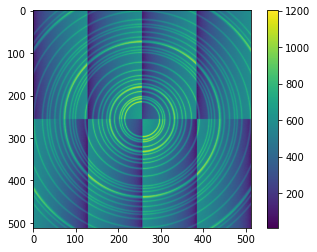

In [7]:
#retrieve image from databroker
my_im = retrieve_im(-1)
#plot
plt.figure()
plt.imshow(my_im)
plt.colorbar()

### Dark image introduction

In [8]:
#we started at t=0, so we'll just go before then to measure the dark.
#time_travel(-1)

RE(light(False))

sim_sleep(10)

RE(count([detector]))

my_dark = catalog[-1].primary.read().detector_image[0]

sleeping for 10


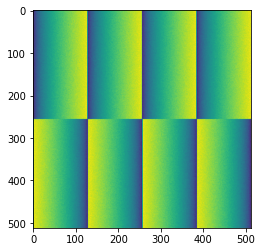

In [9]:
plt.figure()
plt.imshow(my_dark)

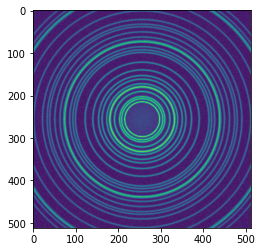

In [10]:
plt.figure()
plt.imshow(my_im - my_dark)

### Integrate to get pattern

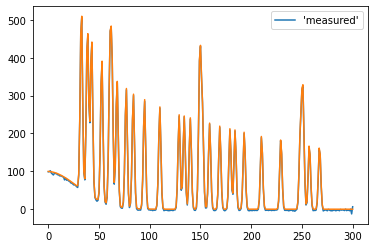

In [11]:
intensity = simple_integration(my_im - my_dark,num_bins=301)

plt.figure()
plt.plot(intensity, label="'measured'")
plt.plot(perfect_int1)
plt.legend()

### Bluesky plan to gather light/dark automatically

#### Demonstrate how to make a simple plan using bluesky (unless we have one already defined at this point).

In [12]:
def dark_light_subtract(sample_num, num_lights = 1):
    uids = []
    #close shutter if not already closed
    yield from light(False)
        
    #move to desired sample
    yield from load_sample(sample_num)
    
    #take dark image
    uid = yield from count([detector])
    uids.append(uid)
    
    #open shutter
    yield from light(True)
    
    #take light image
    for i in range(num_lights):
        uid = yield from count([detector])
        uids.append(uid)
    
    #close shutter to be nice to detector
    yield from light(False)
    return uids

Run engine returns uids

In [13]:
uids = RE(dark_light_subtract(1))

In [14]:
uids

('2a385a74-0424-4def-b92d-c9f3f5bfbb49',
 '6390deeb-e32a-436f-90ad-4b8a81efe599')

#### At beamline, we have autoreduction.  Here, we wrote a helper function called "process_data" which will return your integrated intensity.

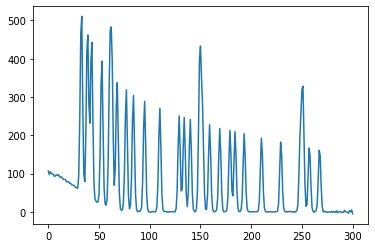

In [15]:
this_intensity = process_data(uids)

plt.figure()
plt.plot(this_intensity)

### Part B: Managing multiple samples.

#### How to Turn-on / Turn-off light, and how to switch between samples.


In [16]:
#history_reset()

RE(light(True))

RE(load_sample(1))

RE(load_sample(2))

RE(load_sample(3))



()

#### Explain that much like many real detectors, our simulated detector has some degree of memory.  Burn-in effects are possible, as are after-image.

In [17]:
uids = RE(dark_light_subtract(1))

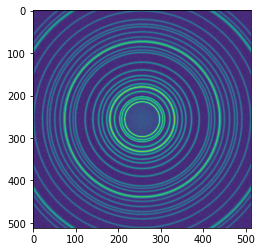

In [18]:
my_light = retrieve_im(uids[1])
my_dark = retrieve_im(uids[0])

plt.figure()
plt.imshow(my_light - my_dark)

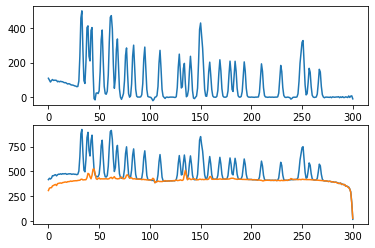

In [19]:
plt.figure()
plt.subplot(211)
plt.plot(process_data(uids))
plt.subplot(212)
plt.plot(process_data(uids,return_light=True))
plt.plot(process_data(uids,return_dark=True))


#### We see features in the dark (peaks), that tell us our dark is kind of no-good.

In [20]:
sim_sleep(100)

uids = RE(dark_light_subtract(1))



sleeping for 100


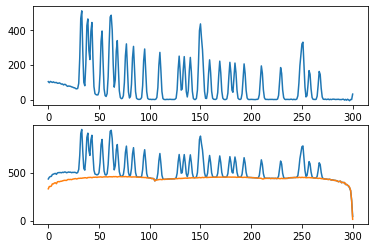

In [21]:
plt.figure()
plt.subplot(211)
plt.plot(process_data(uids))
plt.subplot(212)
plt.plot(process_data(uids,return_light=True))
plt.plot(process_data(uids,return_dark=True))


##### Much cleaner looking dark, no outstanding peaks. Clearly, managment of darks is an important aspect of diffraction measurements (at least on these detectors).

### Part C : More samples, more problems.

#### In a real experement, you often switch between samples, and they don't all scatter the same.  We often measure multiple times on a single sample and sum the results to improve statistics.

In [22]:
#change to noisy detector

_history['noise'] = 1000
_history['action_time'] = 20.0 # 1.0
_history['panel_wl'] = 3000 # 8000

Look at single scan vs. perfect data

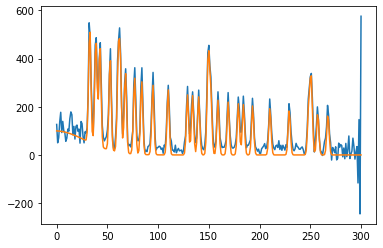

In [23]:
uid = RE(dark_light_subtract(1))
plt.figure()
plt.plot(process_data(uid))
plt.plot(perfect_int1)


Run multiple scans on single sample (single dark)

In [24]:
uids1 = RE(dark_light_subtract(1, num_lights=10))

In [25]:
reduced_data1 = process_data(uids1, num_lights=len(uids1)-1)


Plot vs. Perfect data.

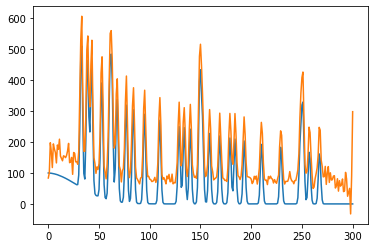

In [26]:
plt.figure()
plt.plot(perfect_int1)
plt.plot(reduced_data1.mean(axis=1));


### Why does our average look so bad?  Huge background.  Let's look at individual runs.

(0.0, 700.0)

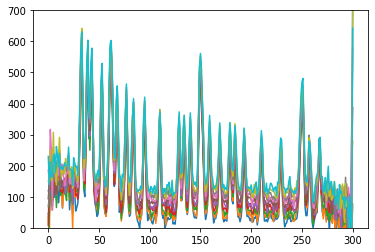

In [27]:
plt.figure()
plt.plot(reduced_data1);

plt.ylim(0,700)

#### We see there is a slowly rising background, which is why our average was corrupted.  What is happening?

#### Just like a real detector, our simulated detector has a slowly varying background.  We need to refresh our dark more frequently to account for this.

Here is a crude plan (RE in a loop) which has a sleep in between our shots, each of which has it's own dark.

In [28]:
history_reset()
new_int_list = []
def custom_plan(sleep_time = 0):
    for i in range(10):
        this_pair = yield from dark_light_subtract(1)
        new_int_list.append(process_data(this_pair))
        sim_sleep(sleep_time)
        
RE(custom_plan(60))

new_int_list = np.array(new_int_list).T

sleeping for 60
sleeping for 60
sleeping for 60
sleeping for 60
sleeping for 60
sleeping for 60
sleeping for 60
sleeping for 60
sleeping for 60
sleeping for 60


Now compare this to the ideal data

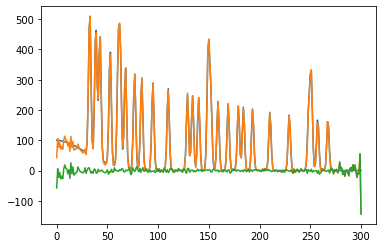

In [29]:
plt.figure()
plt.plot(perfect_int1)
plt.plot(new_int_list.mean(axis=1))
plt.plot(new_int_list.mean(axis=1) - perfect_int1)

## Concluding remarks!